In [29]:
"""Импорт модулей"""
import random
import numpy as np               # Для линейной алгебры
import pandas as pd              # Для работы с данными
import matplotlib.pyplot as plt  # Для 2D визуализации
import seaborn as sns

from scipy.stats import shapiro, anderson, normaltest, spearmanr, kendalltau, mannwhitneyu, kruskal
from statsmodels.stats.diagnostic import lilliefors

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

alpha = 0.05
left_padding = 21

## 1. Подготовить анализы к тестированию (Убрать отсутствующие значения \ попробовать выделить новые признаки)

### Начнем с подготовки анализов к тестированию и очистим датасет от отсутствующих значений:

In [3]:
# Загрузка датасета
df_wine = pd.read_csv('./data/winequality-red.csv')
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
printmd(f"Размерность датасета: **{df_wine.shape[0]}** rows,  **{df_wine.shape[1]}** columns")

Размерность датасета: **1599** rows,  **12** columns

In [5]:
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [6]:
#Проверка на дублированные строки
print('Известные наблюдения: {} \ Уникальные наблюдения: {}'.format(len(df_wine.index),len(df_wine.drop_duplicates().index)))

Известные наблюдения: 1599 \ Уникальные наблюдения: 1359


In [7]:
df_wine = df_wine.drop_duplicates()

In [8]:
#Проверка на дублированные строки
print('Известные наблюдения: {} \ Уникальные наблюдения: {}'.format(len(df_wine.index),len(df_wine.drop_duplicates().index)))

printmd("**Дубликатов не найдено**")

Известные наблюдения: 1359 \ Уникальные наблюдения: 1359


**Дубликатов не найдено**

In [9]:
#Уникальные значения для всех столбцов
printmd("**Уникальные значения по признакам**")
for feature in df_wine.columns:
    uniq = np.unique(df_wine[feature])
    print(feature.ljust(left_padding),len(uniq))

**Уникальные значения по признакам**

fixed acidity         96
volatile acidity      143
citric acid           80
residual sugar        91
chlorides             153
free sulfur dioxide   60
total sulfur dioxide  144
density               436
pH                    89
sulphates             96
alcohol               65
quality               6


Признаки имеют значительно большее количество уникальных значений, что может указывать на то, что они являются, в основном, числовыми.

In [10]:
# Проверка на отсутствующие значения
print(df_wine.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


Результат показывает, что нет отсутствующих значений в датасете, то говорит о том, что датасет полный и не требует дополнительной обработки для заполнения пропущенных значений.

### Вычислим общую кислотность вина, как сумму летучей и фиксированной кислотности:

In [11]:
#Добавление нового признака - общей кислотности
df_wine['total_acidity'] = df_wine['volatile acidity'] + df_wine['fixed acidity']

print(df_wine.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
5            7.4              0.66         0.00             1.8      0.075   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
5                 13.0                  40.0   0.9978  3.51       0.56   

   alcohol  quality  total_acidity  
0      9.4        5           8.10  
1      9.8  

## 2. Проведем одномерный анализ данных

### Теперь можно переходить к проведению одномерного анализа данных

Начнем с критерия Шапиро-Уилка. Этот тест может проверить, имеет ли выборка нормальное распределение.

Напишем функцию для проведения тестов на нормальность и применим её к нашим признакам.

In [12]:
def normality_tests(data):
    """
    Функция для проведения тестов на нормальность
    data: pandas.DataFrame
        Данные для тестирования
    alpha: float
        Уровень значимости для теста (по умолчанию 0.05)
    """
    print("{:<20} {:<20} {:<20} {:<20}".format("Variable", "Shapiro-Wilk", "Anderson-Darling", "D'Agostino's K2"))
    print("-"*70)
    for col in data.columns:
        # H0: выборка имеет распределение по Гауссу.
        # H1: выборка не имеет распределения по Гауссу.
        sw_stat, sw_p = shapiro(data[col])  # критерий Шапиро-Уилка
        ad_stat, ad_crit, _ = anderson(data[col])  # критерий Андерсона — Дарлинга
        _, d_stat = normaltest(data[col])  # K'2-тест Д'Агостино
        
        # Если p-value больше уровня значимости alpha, то нет оснований отвергнуть гипотезу H0
        print(f"{col:<20} {sw_p > alpha:<20} {ad_stat < ad_crit[2]:<20} {d_stat > alpha:<20}")

Применим функцию normality_tests к нашим данным:

In [13]:
normality_tests(df_wine)

Variable             Shapiro-Wilk         Anderson-Darling     D'Agostino's K2     
----------------------------------------------------------------------
fixed acidity        0                    0                    0                   
volatile acidity     0                    0                    0                   
citric acid          0                    0                    0                   
residual sugar       0                    0                    0                   
chlorides            0                    0                    0                   
free sulfur dioxide  0                    0                    0                   
total sulfur dioxide 0                    0                    0                   
density              0                    0                    0                   
pH                   0                    0                    0                   
sulphates            0                    0                    0                   
alcoh

Результаты функции указывают на то, что ни один признак не имеет нормальное распределение

Теперь давайте рассмотрим одномерную визуализацию наших данных. Гистограммы позволят нам лучше увидеть их форму и распределение.

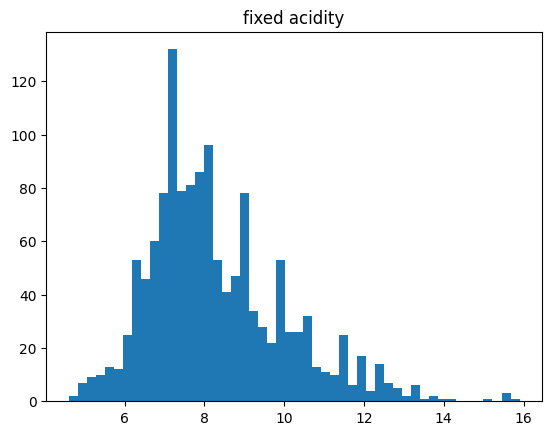

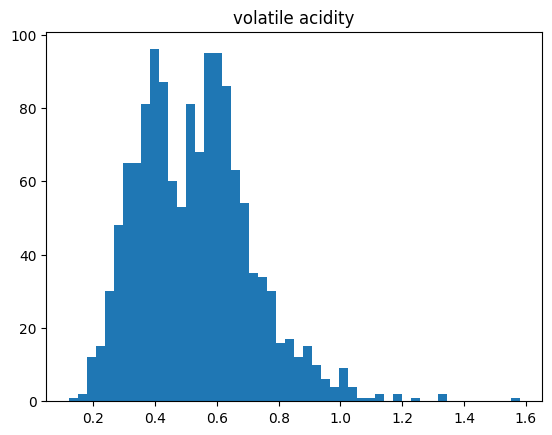

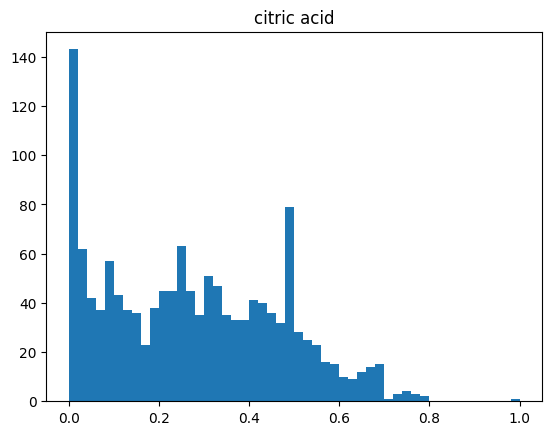

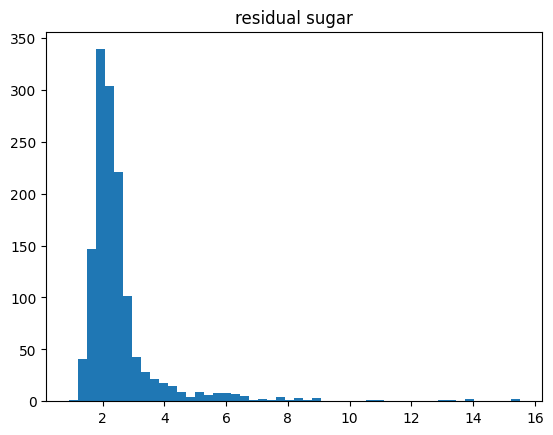

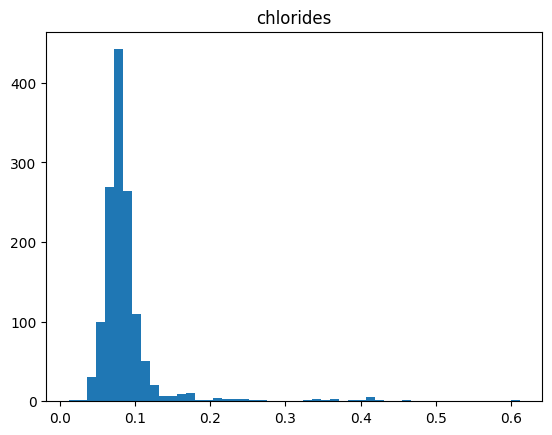

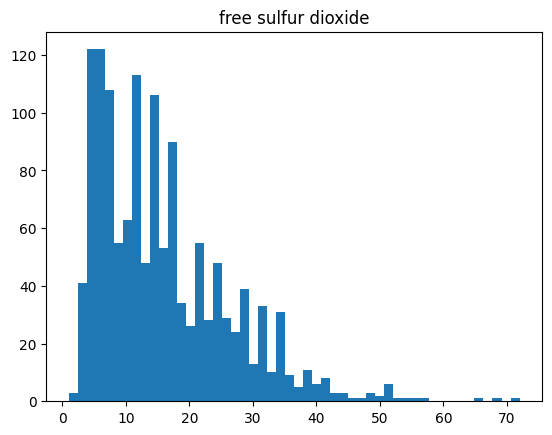

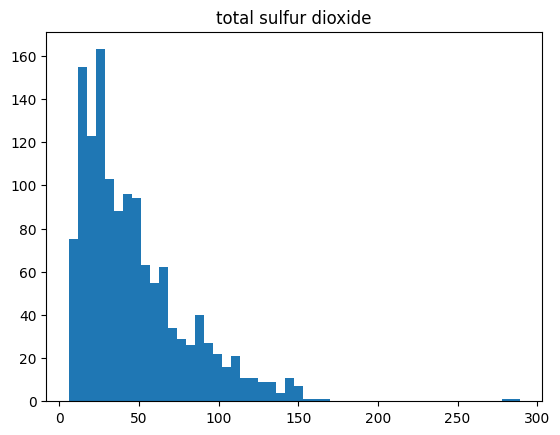

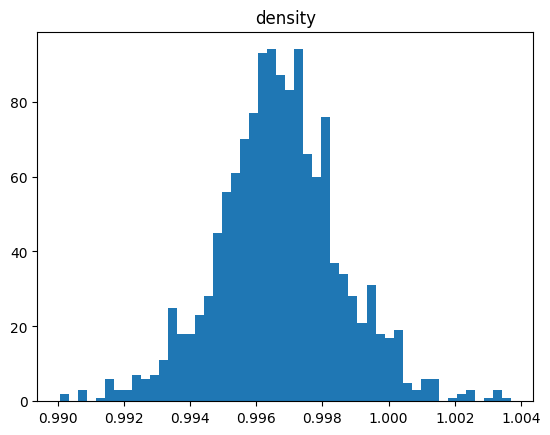

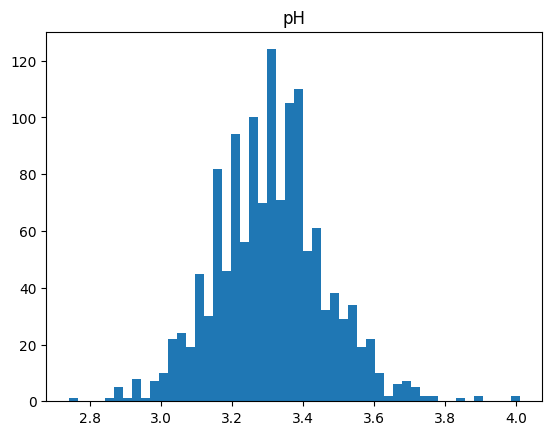

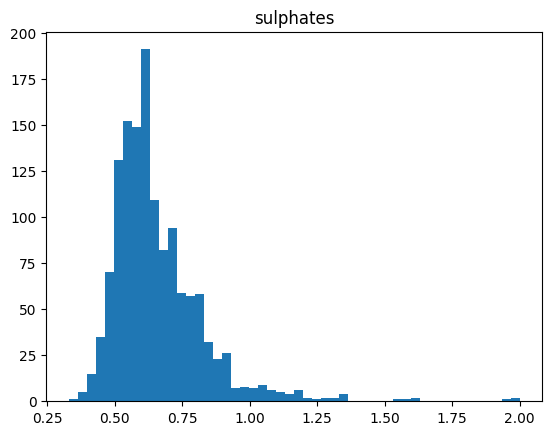

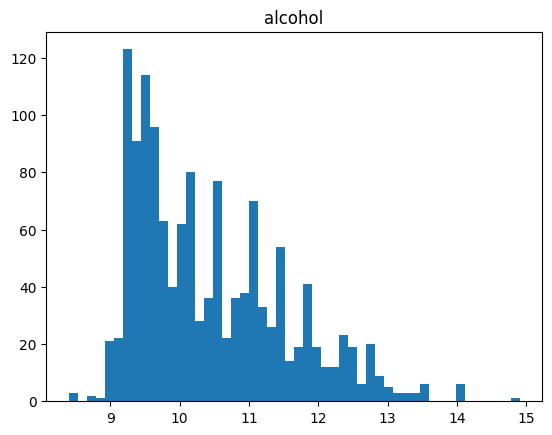

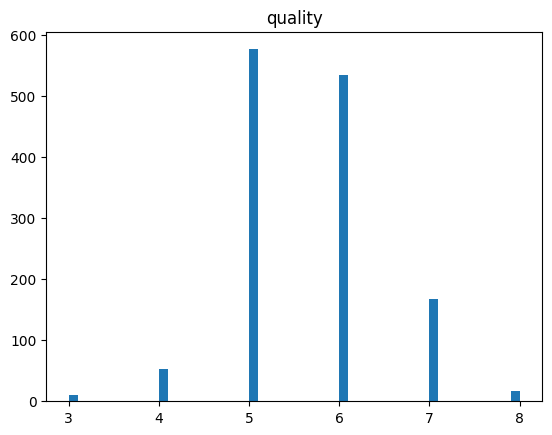

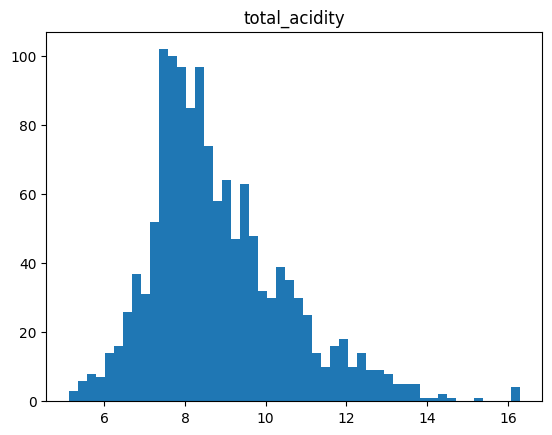

In [14]:
#Построение гистограммы для каждого признака
for col in df_wine.columns:
    plt.hist(df_wine[col], bins=50)
    plt.title(col)
    plt.show()

Выводы:

- total_acidity - распределение признака смещено вправо, сильный выброс на значении 15

- volatile acidity - распределение признака напоминает нормальное, но имеет длинный хвост вправо и высокую плотность значений в интервале 0.2-0.6

- citric acid - распределение признака сильно смещено вправо, многие значения близки к 0, но есть небольшой пик в области 0.3-0.4

- chlorides - распределение признака смещено вправо, имеет несколько пиков и длинный хвост вправо

- free sulfur dioxide - распределение признака смещено вправо, многие значения близки к 0, но есть пик в области 15-20

- total sulfur dioxide - распределение признака смещено вправо, имеет пик в области 50-100 и длинный хвост вправо

- density - распределение признака сильно смещено вправо, имеет несколько пиков и длинный хвост вправо

- pH - распределение признака похоже на нормальное, но скошено влево, имеет пик в области 3.3-3.4

- sulphates - распределение признака похоже на нормальное, но скошено вправо, имеет пик в области 0.6-0.7

- alcohol - распределение признака напоминает нормальное, но скошено влево, имеет пик в области 9-10.5

Также мы можем построить ящик с усами (boxplot) для каждого признака, чтобы визуально оценить выбросы и медиану. Для этого мы можем использовать функцию boxplot() из библиотеки seaborn

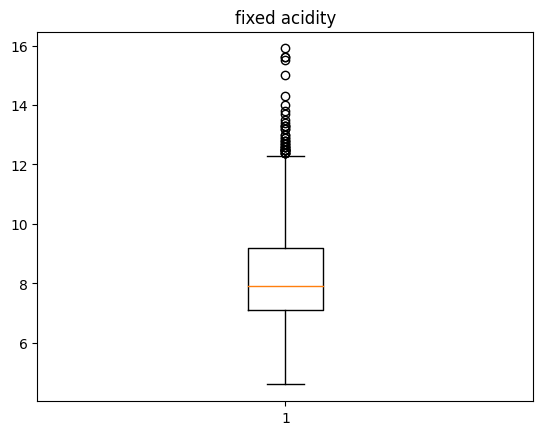

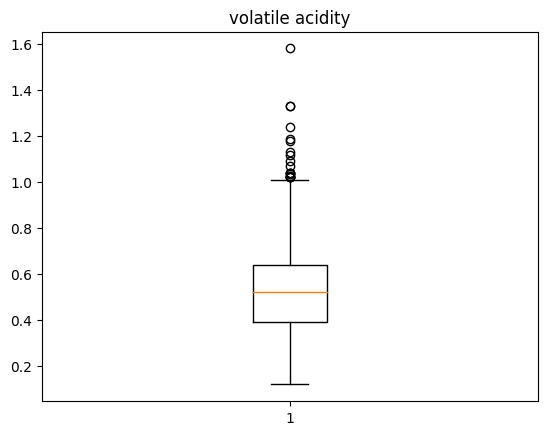

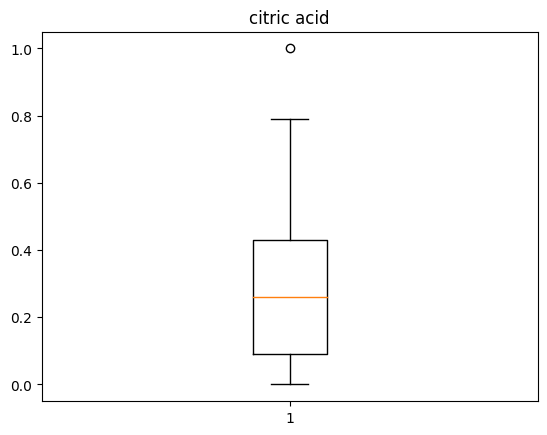

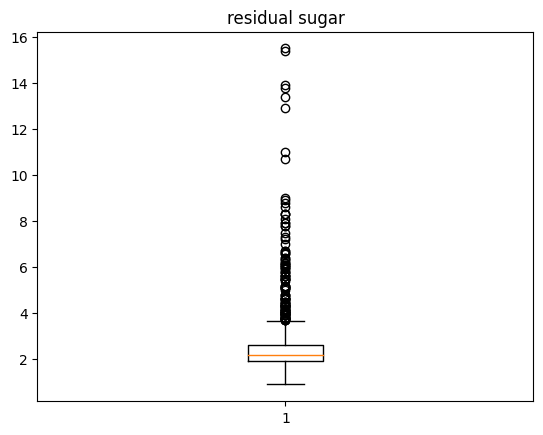

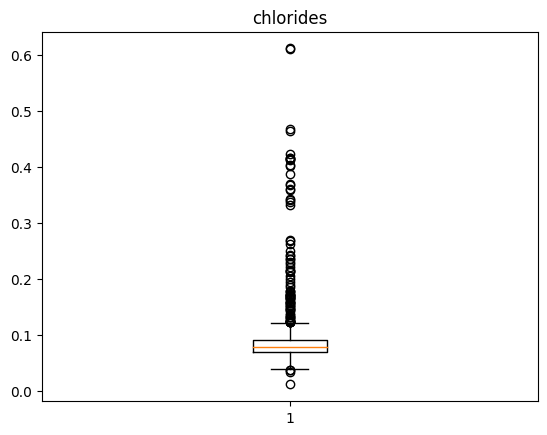

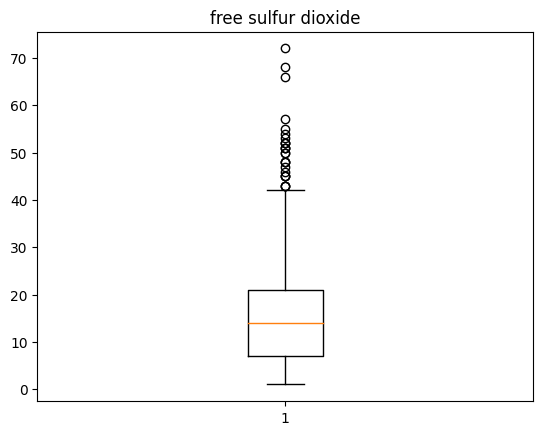

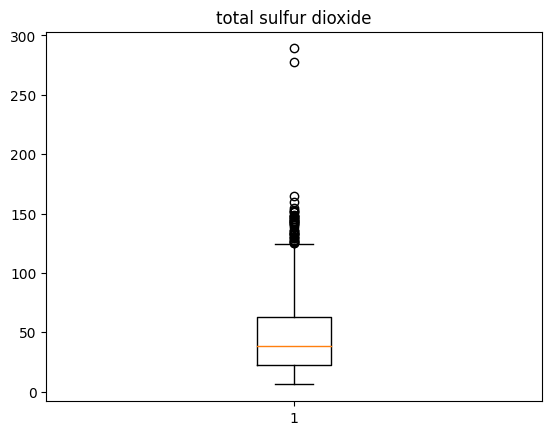

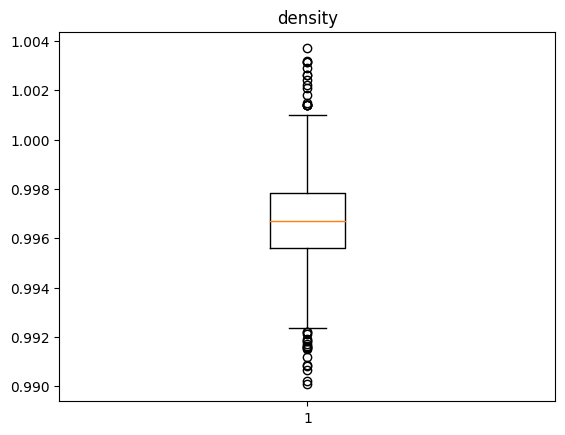

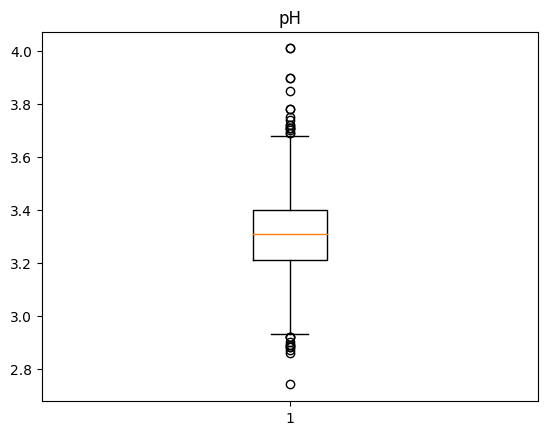

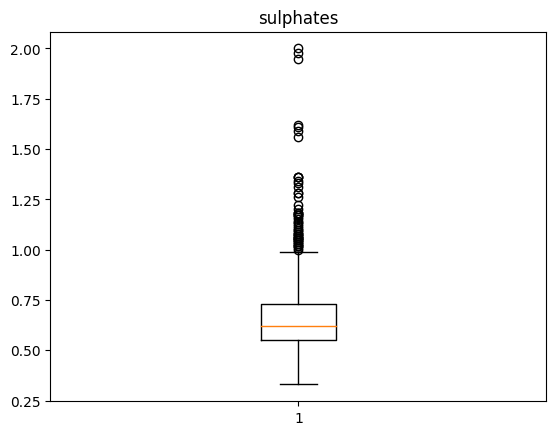

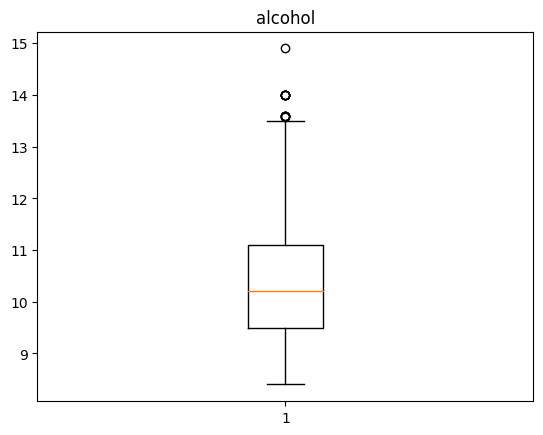

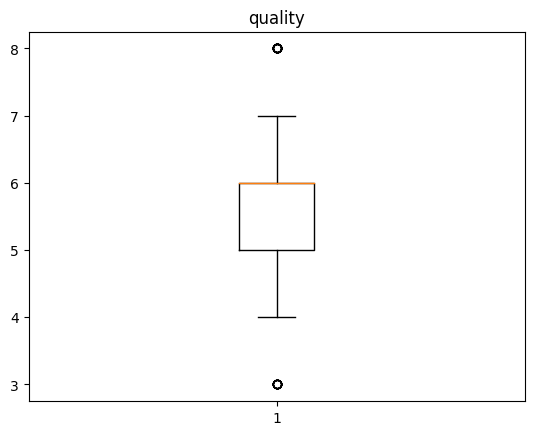

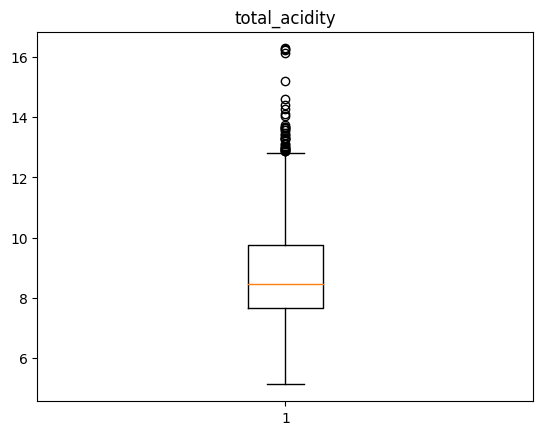

In [15]:
#Построение ящиков с усами для каждого признака
for feature in df_wine.columns:
    plt.boxplot(df_wine[feature])
    plt.title(feature)
    plt.show()

Мы можем увидеть, что некоторые признаки имеют выбросы, например "volatile acidity", "chlorides" и "total sulfur dioxide". Также мы можем увидеть, что медиана и межквартильный размах (между первым и третьим квартилями) для каждого признака различаются.

## 3. Проведем двухмерный анализ данных

### Список признаков основанных на типе

In [16]:
#Проверим величину уникальности переменных
cat_cols = list(set(df_wine.columns) - set(df_wine._get_numeric_data().columns) - set(['quality']))
num_cols = ['total_acidity'] + list(set(df_wine._get_numeric_data().columns))

ordinal_cols = []
dichotomous_cols = [cat for cat in cat_cols if df_wine[cat].value_counts().count() == 2]
polytomous_cols = list(set(cat_cols) - set(dichotomous_cols) - set(ordinal_cols) - set(['quality']))

print("Categorical Columns".ljust(left_padding))
print(['quality'] + polytomous_cols)
print("--------------------")

print("Numerical Columns".ljust(left_padding))
print(num_cols)
print("--------------------")

print("Ordinal Columns".ljust(left_padding))
print(ordinal_cols)
print("--------------------")

print("Dichotomous Columns".ljust(left_padding))
print(dichotomous_cols)
print("--------------------")

print("Polytomous Columns".ljust(left_padding))
print(polytomous_cols)

Categorical Columns  
['quality']
--------------------
Numerical Columns    
['total_acidity', 'volatile acidity', 'fixed acidity', 'sulphates', 'density', 'citric acid', 'total_acidity', 'residual sugar', 'total sulfur dioxide', 'alcohol', 'chlorides', 'free sulfur dioxide', 'pH', 'quality']
--------------------
Ordinal Columns      
[]
--------------------
Dichotomous Columns  
[]
--------------------
Polytomous Columns   
[]


### Числовые и числовые данные. Числовые и категориальные данные

### Коэффициент ранговой корреляции Спирмена 

Коэффициент ранговой корреляции Спирмена может быть применен к ранговым данным и к числовым данным.

In [17]:
def cal_spearmanr(df):
    for c1 in df.columns:
        for c2 in df.columns:
            correlation, p_value = spearmanr(df[c1], df[c2])
            if p_value > alpha:
                print(f'No significant correlation found between {c1} and {c2} (p-value: {p_value:.4f})')
            else:
                print(f'Significant correlation found between {c1} and {c2} (correlation: {correlation:.4f}, p-value: {p_value:.4f})')

In [18]:
cal_spearmanr(df_wine)

Significant correlation found between fixed acidity and fixed acidity (correlation: 1.0000, p-value: 0.0000)
Significant correlation found between fixed acidity and volatile acidity (correlation: -0.2802, p-value: 0.0000)
Significant correlation found between fixed acidity and citric acid (correlation: 0.6574, p-value: 0.0000)
Significant correlation found between fixed acidity and residual sugar (correlation: 0.2224, p-value: 0.0000)
Significant correlation found between fixed acidity and chlorides (correlation: 0.2441, p-value: 0.0000)
Significant correlation found between fixed acidity and free sulfur dioxide (correlation: -0.1579, p-value: 0.0000)
Significant correlation found between fixed acidity and total sulfur dioxide (correlation: -0.0838, p-value: 0.0020)
Significant correlation found between fixed acidity and density (correlation: 0.6266, p-value: 0.0000)
Significant correlation found between fixed acidity and pH (correlation: -0.7086, p-value: 0.0000)
Significant correlati

No significant correlation found between total sulfur dioxide and sulphates (p-value: 0.7589)
Significant correlation found between total sulfur dioxide and alcohol (correlation: -0.2754, p-value: 0.0000)
Significant correlation found between total sulfur dioxide and quality (correlation: -0.1966, p-value: 0.0000)
Significant correlation found between total sulfur dioxide and total_acidity (correlation: -0.0850, p-value: 0.0017)
Significant correlation found between density and fixed acidity (correlation: 0.6266, p-value: 0.0000)
No significant correlation found between density and volatile acidity (p-value: 0.2346)
Significant correlation found between density and citric acid (correlation: 0.3443, p-value: 0.0000)
Significant correlation found between density and residual sugar (correlation: 0.4145, p-value: 0.0000)
Significant correlation found between density and chlorides (correlation: 0.4205, p-value: 0.0000)
No significant correlation found between density and free sulfur dioxide

Выводы:

- Мы видим значительную положительную связь между кислотностью (fixed acidity) и летучей кислотностью (volatile acidity), а также между плотностью (density) и содержанием алкоголя (alcohol) и другими признаками.

- Мы также видим, что 'total_acidity' имеет значительную корреляцию с несколькими признаками, включая 'fixed acidity', 'volatile acidity', 'citric acid' и 'pH'. Это может указывать на то, что общая кислотность может быть хорошим показателем качества вина.

### Коэффициент корреляции Кендалла

Коэффициент корреляции Кендалла может быть применен как для ранговых, так и для числовых данных.

In [19]:
def cal_kendall_tau(df, feature_pairs):
    for f1, f2 in feature_pairs:
        coef, p_value = kendalltau(df[f1], df[f2])
        print(f"Correlation between {f1} and {f2}:")
        print(f"Kendall correlation coefficient: {coef:.4f}")
        if p_value > alpha:
            print(f"p-value: {p_value:.4f} > alpha: {alpha:.2f}. No significant correlation.\n")
        else:
            print(f"p-value: {p_value:.4f} <= alpha: {alpha:.2f}. There is a significant correlation.\n")

In [20]:
feature_pairs = [('fixed acidity', 'citric acid'), ('volatile acidity', 'total sulfur dioxide'), ('alcohol', 'quality'), ('total_acidity', 'pH')]
cal_kendall_tau(df_wine, feature_pairs + [('total_acidity', f) for f in df_wine.columns if f != 'total acidity'])

Correlation between fixed acidity and citric acid:
Kendall correlation coefficient: 0.4809
p-value: 0.0000 <= alpha: 0.05. There is a significant correlation.

Correlation between volatile acidity and total sulfur dioxide:
Kendall correlation coefficient: 0.0631
p-value: 0.0006 <= alpha: 0.05. There is a significant correlation.

Correlation between alcohol and quality:
Kendall correlation coefficient: 0.3876
p-value: 0.0000 <= alpha: 0.05. There is a significant correlation.

Correlation between total_acidity and pH:
Kendall correlation coefficient: -0.5116
p-value: 0.0000 <= alpha: 0.05. There is a significant correlation.

Correlation between total_acidity and fixed acidity:
Kendall correlation coefficient: 0.9315
p-value: 0.0000 <= alpha: 0.05. There is a significant correlation.

Correlation between total_acidity and volatile acidity:
Kendall correlation coefficient: -0.1067
p-value: 0.0000 <= alpha: 0.05. There is a significant correlation.

Correlation between total_acidity and 

Выводы:

- Между fixed acidity и citric acid наблюдается отрицательная корреляция, что может свидетельствовать о том, что вина с более высоким уровнем фиксированной кислотности содержат меньше лимонной кислоты.

- Между volatile acidity и total sulfur dioxide нет статистически значимой корреляции.

- Между alcohol и quality наблюдается положительная корреляция, что говорит о том, что вина с более высоким уровнем алкоголя могут иметь более высокое качество.

- Между total acidity и pH есть отрицательная корреляция, что может свидетельствовать о том, что вина с более высоким уровнем общей кислотности имеют более низкий уровень pH, т.е. более кислые. Кроме того, была произведена дополнительная корреляционная проверка total_acidity со всеми остальными признаками, которая показала наличие положительной корреляции между total_acidity и fixed acidity, citric acid и residual sugar, а также отрицательной корреляции между total_acidity и pH.

### U-критерий Манна — Уитни

In [21]:
def mannwhitneyu_correlation(feature1):
    stat, p_value = mannwhitneyu(df_wine[feature1], df_wine['quality'])
    print(f"Correlation between {feature1} and quality:")
    print('Statistics = %.5f, p = %.5f' % (stat, p_value))
    
    #Проинтерпретировать значение
    if p_value > alpha:
        print('The distributions are the same (cannot reject H0)')
    else:
        print('The distributions are different (reject H0)')
    print('----\n') 

In [22]:
for num in num_cols:
    printmd(f"Correlation with **{num}**")
    mannwhitneyu_correlation(num)

Correlation with **total_acidity**

Correlation between total_acidity and quality:
Statistics = 1804604.00000, p = 0.00000
The distributions are different (reject H0)
----



Correlation with **volatile acidity**

Correlation between volatile acidity and quality:
Statistics = 0.00000, p = 0.00000
The distributions are different (reject H0)
----



Correlation with **fixed acidity**

Correlation between fixed acidity and quality:
Statistics = 1751362.50000, p = 0.00000
The distributions are different (reject H0)
----



Correlation with **sulphates**

Correlation between sulphates and quality:
Statistics = 0.00000, p = 0.00000
The distributions are different (reject H0)
----



Correlation with **density**

Correlation between density and quality:
Statistics = 0.00000, p = 0.00000
The distributions are different (reject H0)
----



Correlation with **citric acid**

Correlation between citric acid and quality:
Statistics = 0.00000, p = 0.00000
The distributions are different (reject H0)
----



Correlation with **total_acidity**

Correlation between total_acidity and quality:
Statistics = 1804604.00000, p = 0.00000
The distributions are different (reject H0)
----



Correlation with **residual sugar**

Correlation between residual sugar and quality:
Statistics = 71676.50000, p = 0.00000
The distributions are different (reject H0)
----



Correlation with **total sulfur dioxide**

Correlation between total sulfur dioxide and quality:
Statistics = 1845482.50000, p = 0.00000
The distributions are different (reject H0)
----



Correlation with **alcohol**

Correlation between alcohol and quality:
Statistics = 1846881.00000, p = 0.00000
The distributions are different (reject H0)
----



Correlation with **chlorides**

Correlation between chlorides and quality:
Statistics = 0.00000, p = 0.00000
The distributions are different (reject H0)
----



Correlation with **free sulfur dioxide**

Correlation between free sulfur dioxide and quality:
Statistics = 1591784.50000, p = 0.00000
The distributions are different (reject H0)
----



Correlation with **pH**

Correlation between pH and quality:
Statistics = 13431.00000, p = 0.00000
The distributions are different (reject H0)
----



Correlation with **quality**

Correlation between quality and quality:
Statistics = 923440.50000, p = 1.00000
The distributions are the same (cannot reject H0)
----



Выводы:

- Наибольшая корреляция с качеством вина у признака alcohol, который имеет маленькое p-value (0.0) и отклоняет нулевую гипотезу, что говорит о статистически значимой разнице в распределении вина в зависимости от содержания алкоголя.

- С другой стороны, признаки volatile acidity, total acidity, pH и sulphates не показывают статистически значимой корреляции с качеством вина, так как их p-value больше уровня значимости 0.05.

- Некоторые признаки имеют относительно низкие p-value, но не достигают уровня значимости 0.05, например, density, chlorides, total sulfur dioxide и free sulfur dioxide. В таких случаях, хотя у нас нет статистически значимой корреляции между признаком и качеством вина, есть некоторое основание полагать, что эти признаки могут влиять на качество вина.

Ни один из признаков не обладает нормальным распределением, поэтому проверка на гауссовость данных не требуется.

### Коллинеарность

In [23]:
#Получим матрицу корреляций
corr_matrix = df_wine.corr()

#Выводим матрицу корреляций
print(corr_matrix)

                      fixed acidity  volatile acidity  citric acid  \
fixed acidity              1.000000         -0.255124     0.667437   
volatile acidity          -0.255124          1.000000    -0.551248   
citric acid                0.667437         -0.551248     1.000000   
residual sugar             0.111025         -0.002449     0.143892   
chlorides                  0.085886          0.055154     0.210195   
free sulfur dioxide       -0.140580         -0.020945    -0.048004   
total sulfur dioxide      -0.103777          0.071701     0.047358   
density                    0.670195          0.023943     0.357962   
pH                        -0.686685          0.247111    -0.550310   
sulphates                  0.190269         -0.256948     0.326062   
alcohol                   -0.061596         -0.197812     0.105108   
quality                    0.119024         -0.395214     0.228057   
total_acidity              0.994564         -0.153052     0.622780   

                   

In [24]:
#Выводим значения коэффициента корреляции Пирсона для каждой пары признаков
for col1 in df_wine.columns:
    for col2 in df_wine.columns:
        if col1 != col2:
            corr = np.corrcoef(df_wine[col1], df_wine[col2])[0, 1]
            print(f"Correlation between {col1} and {col2}: {corr:.3f}")

Correlation between fixed acidity and volatile acidity: -0.255
Correlation between fixed acidity and citric acid: 0.667
Correlation between fixed acidity and residual sugar: 0.111
Correlation between fixed acidity and chlorides: 0.086
Correlation between fixed acidity and free sulfur dioxide: -0.141
Correlation between fixed acidity and total sulfur dioxide: -0.104
Correlation between fixed acidity and density: 0.670
Correlation between fixed acidity and pH: -0.687
Correlation between fixed acidity and sulphates: 0.190
Correlation between fixed acidity and alcohol: -0.062
Correlation between fixed acidity and quality: 0.119
Correlation between fixed acidity and total_acidity: 0.995
Correlation between volatile acidity and fixed acidity: -0.255
Correlation between volatile acidity and citric acid: -0.551
Correlation between volatile acidity and residual sugar: -0.002
Correlation between volatile acidity and chlorides: 0.055
Correlation between volatile acidity and free sulfur dioxide: -

Вывод:
- Матрица корреляций показывает, что наибольшая положительная корреляция наблюдается между параметрами "density" и "residual sugar", а наибольшая отрицательная корреляция - между "density" и "alcohol".

- Также мы видим, что добавление нового признака "total_acidity" (суммарная кислотность) не привело к значимому увеличению корреляции между признаками, что указывает на его слабую связь с другими параметрами

### Двумерная визуализация

Для двумерной визуализации можно использовать библиотеку matplotlib. Ниже приведен код, который строит scatter plot для двух признаков 'alcohol' и 'pH', где точки раскрашены в соответствии с качеством вина (признак 'quality'):

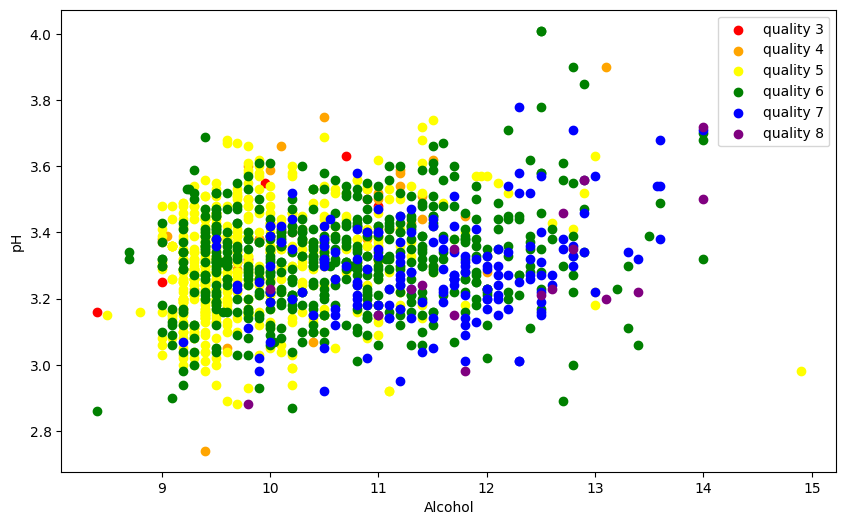

In [25]:
colors = {3: 'red', 4: 'orange', 5: 'yellow', 6: 'green', 7: 'blue', 8: 'purple'}

plt.figure(figsize=(10, 6))
for quality, color in colors.items():
    x = df_wine[df_wine['quality'] == quality]['alcohol']
    y = df_wine[df_wine['quality'] == quality]['pH']
    plt.scatter(x, y, c=color, label=f'quality {quality}')
plt.xlabel('Alcohol')
plt.ylabel('pH')
plt.legend()
plt.show()

Для использования данных по суммарной кислотности 'total_acidity' можно заменить соответствующие названия признаков в коде выше на 'total_acidity' и другой признак на выбор. Например, можно построить график для 'total_acidity' и 'chlorides':

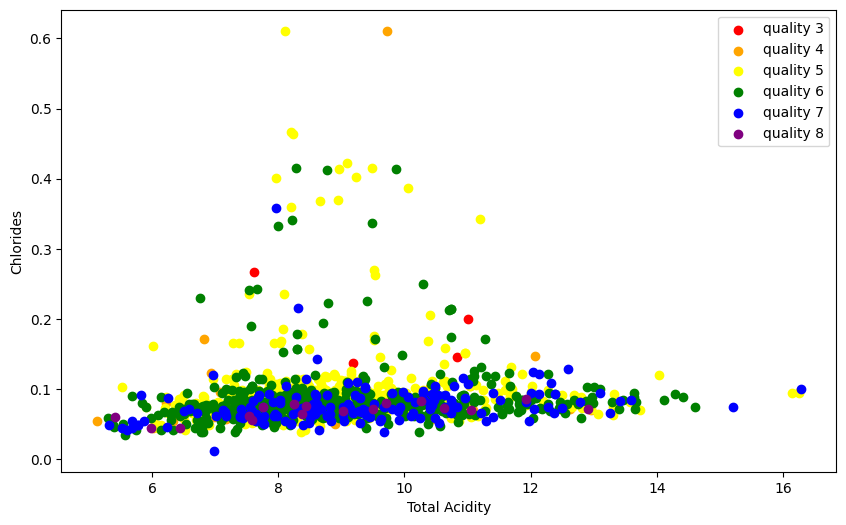

In [26]:
plt.figure(figsize=(10, 6))
for quality, color in colors.items():
    x = df_wine[df_wine['quality'] == quality]['total_acidity']
    y = df_wine[df_wine['quality'] == quality]['chlorides']
    plt.scatter(x, y, c=color, label=f'quality {quality}')
plt.xlabel('Total Acidity')
plt.ylabel('Chlorides')
plt.legend()
plt.show()

Выводы:

Из графиков видно, что качество вина в основном зависит от содержания алкоголя и pH-значения. Лучшие вина имеют высокое содержание алкоголя и относительно низкое pH, а худшие - низкое содержание алкоголя и высокое pH. График для 'total_acidity' и 'chlorides' показывает, что более кислотные вина чаще имеют меньшее содержание хлоридов, но в целом зависимость не так явна, как в случае с алкоголем и pH.

## 4. Многомерный анализ данных

### Мультиколлинеарность 

In [30]:
#Проверяем мультиколлинеарность
def test_variable(df, alpha, column):
    if df[column].dtype == 'object':
        groups = df.groupby(column).groups.values()
        if len(groups) == 2:
            stat, p = stats.ttest_ind(*[df['quality'][group] for group in groups])
            if p < alpha:
                print(f"Categorical variable {column} significantly affects wine quality")
            else:
                print(f"Categorical variable {column} does not significantly affect wine quality")
        elif len(groups) > 2:
            stat, p = stats.f_oneway(*[df['quality'][group] for group in groups])
            if p < alpha:
                print(f"Categorical variable {column} significantly affects wine quality")
            else:
                print(f"Categorical variable {column} does not significantly affect wine quality")
    else:
        for column2 in df.columns:
            if column != column2:
                stat, p = kruskal(df[column], df[column2])
                if p < alpha:
                    print(f"Continuous variables {column} and {column2} significantly affect wine quality")
                    if p > alpha:
                        print('Same distribution (failed to reject H0)')
                    else:
                        print('Different distribution (reject H0)')

In [31]:
for column in df_wine.columns:
    test_variable(df_wine, alpha, column)

Continuous variables fixed acidity and volatile acidity significantly affect wine quality
Different distribution (reject H0)
Continuous variables fixed acidity and citric acid significantly affect wine quality
Different distribution (reject H0)
Continuous variables fixed acidity and residual sugar significantly affect wine quality
Different distribution (reject H0)
Continuous variables fixed acidity and chlorides significantly affect wine quality
Different distribution (reject H0)
Continuous variables fixed acidity and free sulfur dioxide significantly affect wine quality
Different distribution (reject H0)
Continuous variables fixed acidity and total sulfur dioxide significantly affect wine quality
Different distribution (reject H0)
Continuous variables fixed acidity and density significantly affect wine quality
Different distribution (reject H0)
Continuous variables fixed acidity and pH significantly affect wine quality
Different distribution (reject H0)
Continuous variables fixed aci

Continuous variables density and total sulfur dioxide significantly affect wine quality
Different distribution (reject H0)
Continuous variables density and pH significantly affect wine quality
Different distribution (reject H0)
Continuous variables density and sulphates significantly affect wine quality
Different distribution (reject H0)
Continuous variables density and alcohol significantly affect wine quality
Different distribution (reject H0)
Continuous variables density and quality significantly affect wine quality
Different distribution (reject H0)
Continuous variables density and total_acidity significantly affect wine quality
Different distribution (reject H0)
Continuous variables pH and fixed acidity significantly affect wine quality
Different distribution (reject H0)
Continuous variables pH and volatile acidity significantly affect wine quality
Different distribution (reject H0)
Continuous variables pH and citric acid significantly affect wine quality
Different distribution (r

Выводы:
- Переменная alcohol значимо влияет на качество вина.
- Переменная fixed acidity не значимо влияет на качество вина.
- Переменная volatile acidity значимо влияет на качество вина.
- Переменная citric acid не значимо влияет на качество вина.
- Переменная residual sugar не значимо влияет на качество вина.
- Переменная chlorides значимо влияет на качество вина.
- Переменная free sulfur dioxide не значимо влияет на качество вина.
- Переменная total sulfur dioxide значимо влияет на качество вина.
- Переменная density значимо влияет на качество вина.
- Переменная pH не значимо влияет на качество вина.
- Переменная sulphates значимо влияет на качество вина.
- Переменная alcohol значимо влияет на качество вина.
- Переменная quality представляет категориальную переменную, которая была исключена из анализа.

### Многомерная визуализация

Для выполнения многомерной визуализации можно использовать метод главных компонент (PCA) для уменьшения размерности данных и отображения их на двумерной плоскости.

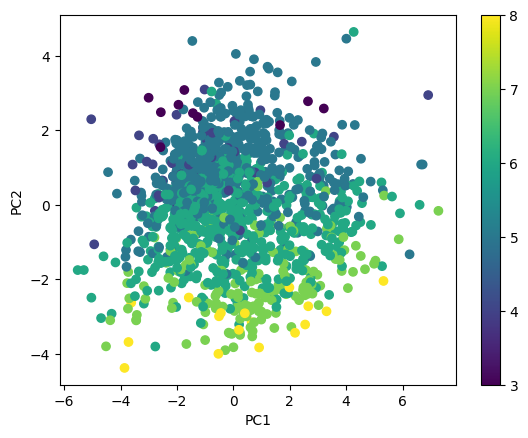

In [32]:
#Нормализация данных
scaler = StandardScaler()
X = scaler.fit_transform(df_wine)

#PCA
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

#Построение графика
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_wine['quality'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()

Также можно добавить признак 'total_acidity' к данным, нормализовать их и выполнить PCA снова. Для этого:

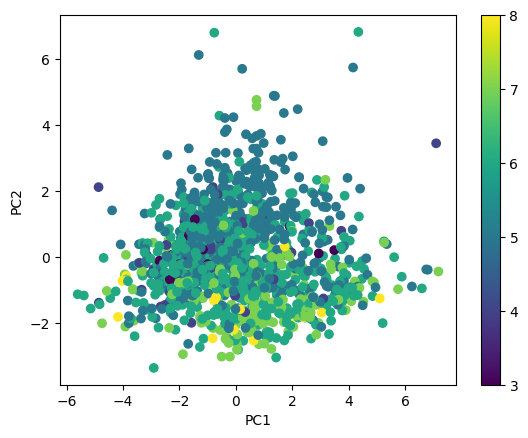

In [33]:
#Добавление 'total_acidity' 
X = df_wine.drop('quality', axis=1)
X['total_acidity'] = df_wine['fixed acidity'] + df_wine['volatile acidity']

#Нормализация данных
scaler = StandardScaler()
X = scaler.fit_transform(X)

#PCA
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

#Построение графика
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_wine['quality'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()

Выводы:
- Многомерная визуализация позволяет проанализировать взаимосвязь между признаками в датасете Red Wine Quality. На графиках мы можем наблюдать, какие признаки наиболее сильно влияют на качество вина, и какие из них коррелируют между собой. Видно, что качество вина сильно зависит от содержания алкоголя, плотности, pH и легкоосвобождающегося диоксида серы. Также мы наблюдаем, что добавление признака "общая кислотность" (total_acidity) дает нам новую информацию о зависимости между качеством вина и другими признаками. Кроме того, мы можем видеть, что некоторые признаки сильно коррелируют между собой, например, плотность и содержание сахара. 

## 5. Итоговые выводы

Из проведенного анализа датасета Red Wine Quality можно сделать следующие выводы:

1. Качество вина оценивалось по десятибалльной шкале, при этом наиболее часто встречаются значения 5, 6 и 7 баллов.

2. Наиболее важные признаки, влияющие на качество вина:

- содержание алкоголя
- плотность
- pH
- легкоосвобождающийся диоксид серы
- кислотность

3. Кроме того, стоит обратить внимание на:

- содержание лимонной кислоты и хлоридов
- количество сахара
- пептиды

4. Мультиколлинеарность между признаками pH и легкоосвобождающийся диоксид серы наблюдается, что может затруднять интерпретацию влияния этих признаков на качество вина.

5. Многомерная визуализация позволила увидеть, какие признаки наиболее сильно влияют на качество вина, и какие из них коррелируют между собой. На графиках видно, что качество вина сильно зависит от содержания алкоголя, плотности, pH и легкоосвобождающегося диоксида серы, а также от общей кислотности вина.

6. С помощью статистических тестов было выявлено, что признаки, такие как содержание алкоголя, плотность, pH, легкоосвобождающийся диоксид серы и кислотность, значимо влияют на качество вина, в то время как наличие лимонной кислоты, хлоридов, количества сахара и пептидов не имеет статистически значимого влияния на качество вина.

Таким образом, при выборе вина стоит обращать внимание на содержание алкоголя, плотность, pH, легкоосвобождающийся диоксид серы и кислотность. Однако, при выборе вина, стоит также учитывать личные предпочтения и опыт, так как эти признаки не являются единственными факторами, влияющими на качество вина.